In [2]:
import pandas as pd

In [3]:
import os

In [4]:
import cv2
import matplotlib.pyplot as plt

In [1]:
!nvidia-smi

Fri May 31 04:38:43 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   36C    P0    56W / 400W |   2035MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   

# For visualize

In [14]:
import cv2
import matplotlib.pyplot as plt

def detect_img(indices):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    # Loop through each index and subplot position
    for idx, ax in zip(indices, axes.flatten()):
        try:
            # Load YOLO annotations
            yolo_annotations_file = f"../runs/detect/predict/labels/{idx}.txt"
            with open(yolo_annotations_file, "r") as f:
                yolo_annotations = f.readlines()
        except:
            print(f"No Label for index {idx}")
            continue

        # Load image
        image_path = f'../runs/detect/predict/{idx}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image for index {idx}")
            continue

        height, width, _ = image.shape

        # Iterate over YOLO annotations
        for annotation_line in yolo_annotations:
            parts = annotation_line.strip().split()
            label, x_center, y_center, box_width, box_height = map(float, parts)

            # Convert YOLO coordinates to pixel coordinates
            x_min = int((x_center - box_width / 2) * width)
            y_min = int((y_center - box_height / 2) * height)
            x_max = int((x_center + box_width / 2) * width)
            y_max = int((y_center + box_height / 2) * height)

            # Draw bounding box on the image
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Convert image from BGR to RGB for Matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image with the annotation using Matplotlib
        ax.imshow(image_rgb)
        ax.set_title(f"Class: {label}")
        ax.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()



In [12]:
def read_label(idx):
    try:
      yolo_annotations = []
      yolo_annotations_file = f"../runs/detect/predict/labels/{idx}.txt"
      with open(yolo_annotations_file, "r") as f:
          yolo_annotations = f.readlines()
    except:
      print("No Label")
      return 

    for annotation_line in yolo_annotations:
        parts = annotation_line.strip().split()
        label, x_center, y_center, box_width, box_height = map(float, parts)

        return label

In [10]:
directory = '../runs/detect/predict/labels'
file_label_list = []

for filename in os.listdir(directory):

    if os.path.isfile(os.path.join(directory, filename)):

        with open(os.path.join(directory, filename), 'r') as file:

            file_label_list.append(filename)

print(file_label_list[:5])

['201.txt', '62795.txt', '108518.txt', '120676.txt', '97201.txt']


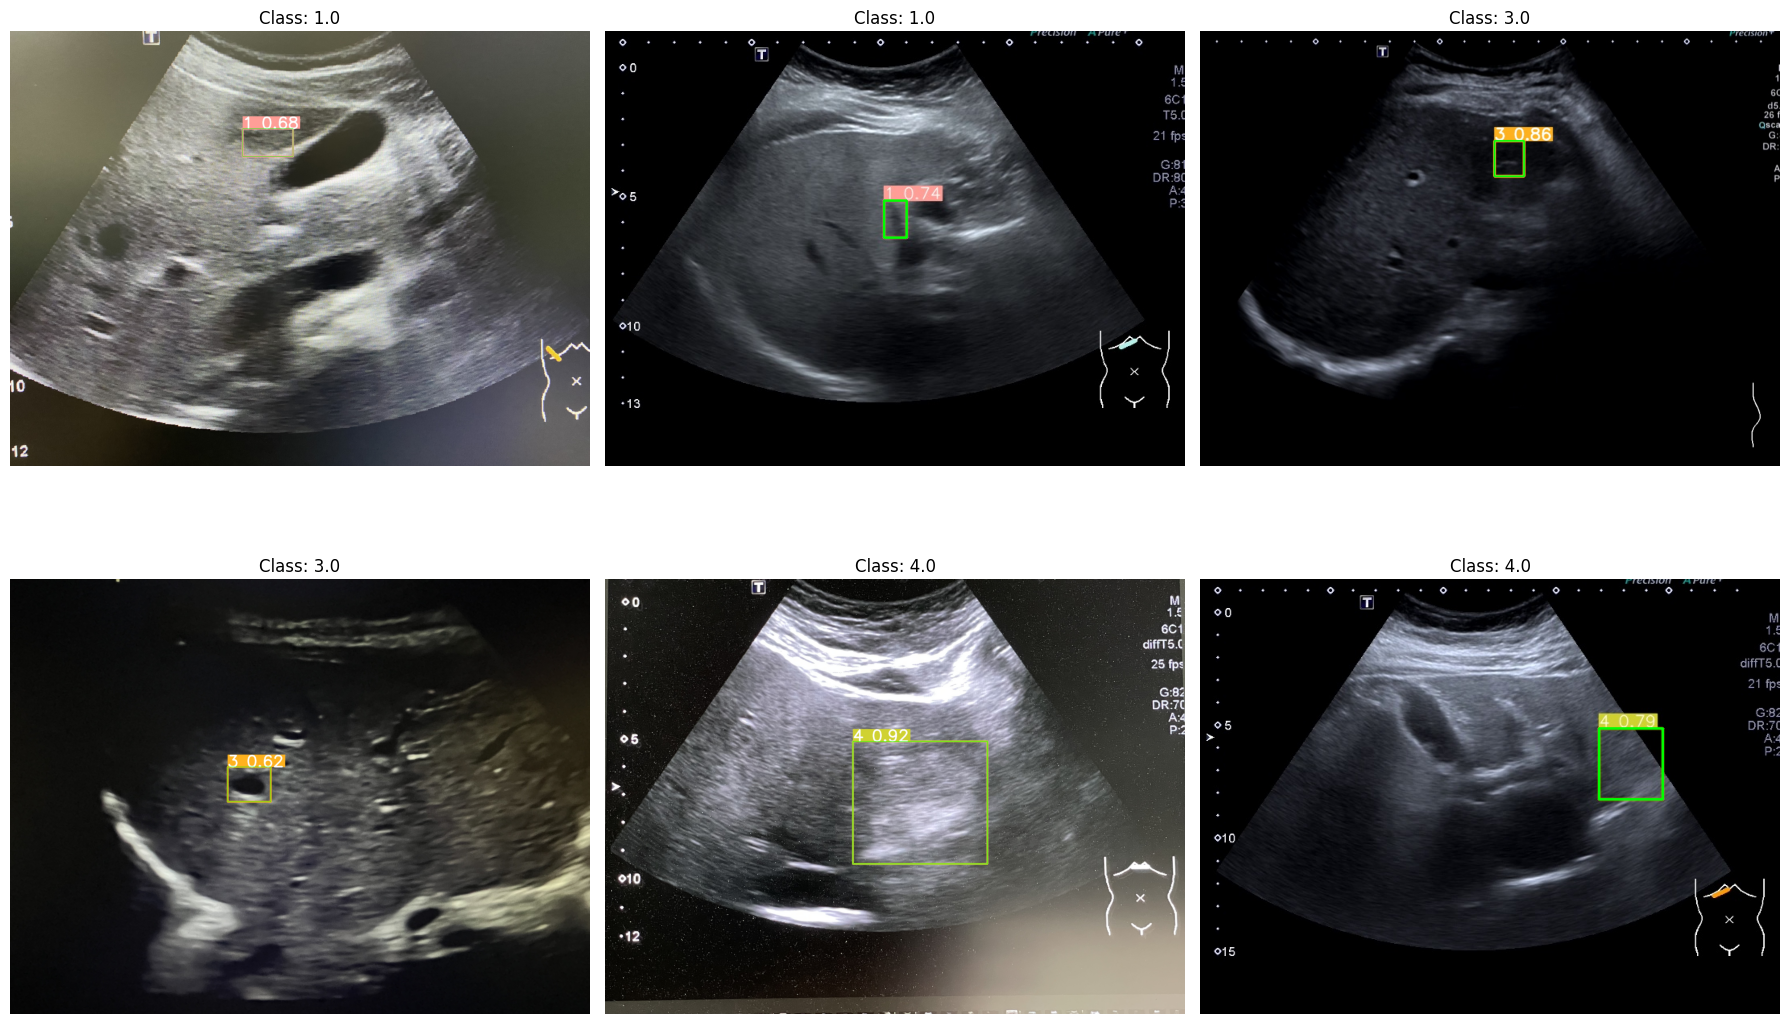

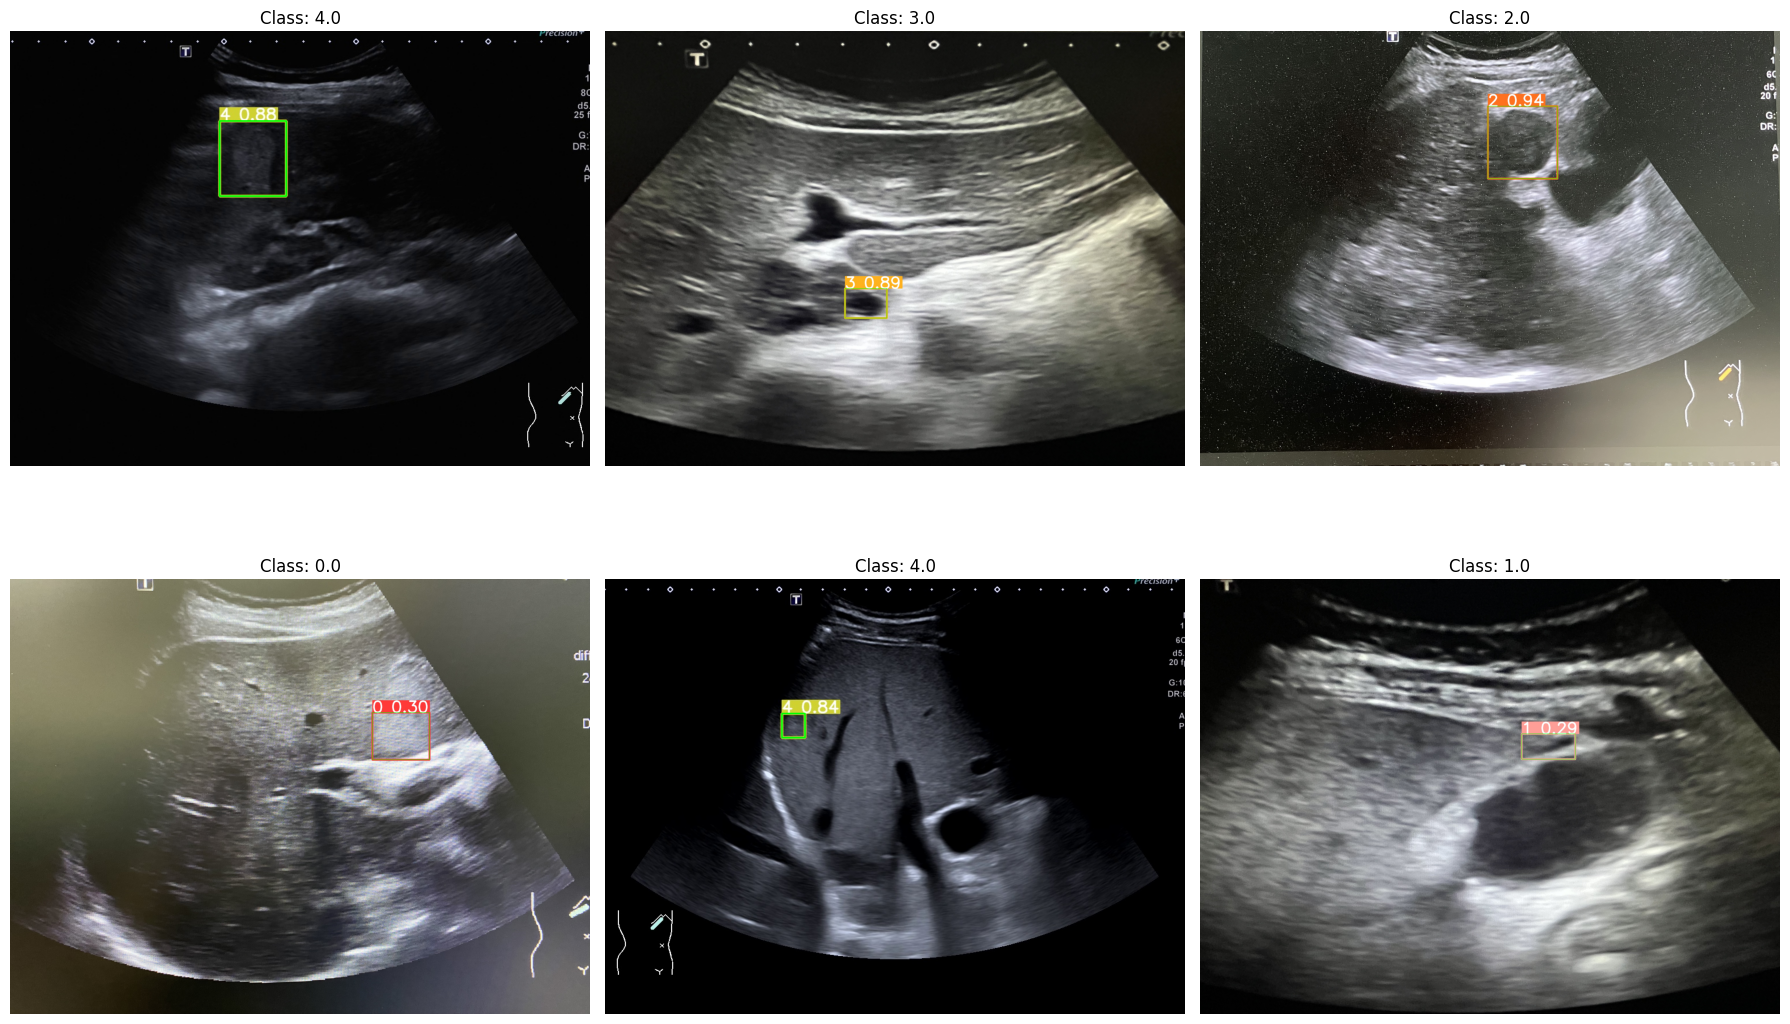

In [37]:
indices = []
num = 0
for file_name in file_label_list:
  idx = file_name.split(".")
  class_id = read_label(idx[0])
  indices.append(idx[0])
  if len(indices) == 6:
      detect_img(indices)
      indices = []
      num += 1
      if num == 2: break

# For prediction

In [16]:
def convert_yolo_to_pascal_df(image_path, yolo_predictions):
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    boxes = []
    labels = []
    for prediction in yolo_predictions:
        class_id, x_center, y_center, width, height = map(float, prediction.split())
        x_min = int((x_center - width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        x_max = int((x_center + width / 2) * image_width)
        y_max = int((y_center + height / 2) * image_height)

        idx = os.path.basename(image_path)
        just_name = idx.split(".")

        box = [x_min, y_min, x_max, y_max]
        label = int(class_id)
        boxes.append(box)
        labels.append(label)

    return {'Image File': just_name[0], 'Annotation': boxes, 'Label': labels}

In [95]:

yolo_predictions = []
with open("../runs/detect/predict3/labels/100206.txt", "r") as file:
    yolo_predictions = file.read().splitlines()


image_path = "../runs/detect/predict3/100206.jpg"  # Replace with the actual image path


pascal_df_data = convert_yolo_to_pascal_df(image_path, yolo_predictions)
pascal_df = pd.DataFrame([pascal_df_data])
pascal_df

Image File                                         Annotation         Label
0     100206  [[184, 170, 256, 228], [185, 171, 278, 230], [...  [0, 0, 0, 0]

# Predict

In [96]:
sample_sub = pd.read_csv("../csv/sample_submission.csv")
sample_sub

Image File                                         Annotation Label
0          18999  [[210.75, 245.33333333333334, 254.25, 354.6666...   [1]
1         102037      [[197.25, 228.0, 269.25, 350.66666666666663]]   [4]
2         138340        [[63.75, 313.33333333333326, 133.5, 444.0]]   [4]
3         140589                                                NaN   NaN
4          20235                                                NaN   NaN
...          ...                                                ...   ...
5148        3575                                                NaN   NaN
5149         190                                                NaN   NaN
5150        1404                                                NaN   NaN
5151         184                                                NaN   NaN
5152        1376                                                NaN   NaN

[5153 rows x 3 columns]

In [97]:
from tqdm import tqdm

In [98]:
all_dataframes = []
for i in tqdm(range(len(sample_sub))):
    idx = sample_sub['Image File'][i]
    try:
        yolo_predictions = []
        with open(f"../runs/detect/predict3/labels/{idx}.txt", "r") as file:
            yolo_predictions = file.read().splitlines()
        image_path = f"../runs/detect/predict3/{idx}.jpg"  
    except: continue

    
    pascal_df_data = convert_yolo_to_pascal_df(image_path, yolo_predictions)
    all_dataframes.append(pascal_df_data)


100%|██████████| 5153/5153 [03:35<00:00, 23.92it/s] 


In [99]:
df = pd.DataFrame(all_dataframes)
df

Image File                                         Annotation      Label
0         18999  [[329, 171, 539, 372], [281, 181, 329, 271], [...  [3, 1, 3]
1        102037  [[272, 171, 372, 265], [272, 171, 372, 265], [...  [4, 4, 4]
2        138340         [[90, 202, 181, 322], [90, 202, 181, 322]]     [4, 4]
3        140589  [[595, 375, 662, 435], [595, 375, 662, 434], [...  [4, 4, 4]
4         20235       [[293, 115, 336, 151], [293, 115, 336, 151]]     [1, 1]
...         ...                                                ...        ...
1872     104071   [[1300, 594, 1468, 932], [1300, 594, 1468, 932]]     [1, 1]
1873        780   [[511, 1500, 891, 1828], [656, 1200, 915, 1448]]     [4, 3]
1874      48030                           [[2667, 654, 2895, 849]]        [3]
1875     115182  [[735, 1401, 1152, 1672], [735, 1401, 1152, 16...     [0, 0]
1876     137687                         [[1042, 1652, 1465, 1992]]        [2]

[1877 rows x 3 columns]

In [78]:
df['Image File'].dtype.name

'object'

In [79]:
import numpy as np

df['Image File'] = df['Image File'].astype(np.int64)

In [88]:
df['Image File'].dtype.name

'int64'

In [86]:
sample_sub

Image File                                         Annotation Label
0          18999  [[210.75, 245.33333333333334, 254.25, 354.6666...   [1]
1         102037      [[197.25, 228.0, 269.25, 350.66666666666663]]   [4]
2         138340        [[63.75, 313.33333333333326, 133.5, 444.0]]   [4]
3         140589                                                NaN   NaN
4          20235                                                NaN   NaN
...          ...                                                ...   ...
5148        3575                                                NaN   NaN
5149         190                                                NaN   NaN
5150        1404                                                NaN   NaN
5151         184                                                NaN   NaN
5152        1376                                                NaN   NaN

[5153 rows x 3 columns]

In [87]:
save_sample = sample_sub[:3]
save_sample

Image File                                         Annotation Label
0       18999  [[210.75, 245.33333333333334, 254.25, 354.6666...   [1]
1      102037      [[197.25, 228.0, 269.25, 350.66666666666663]]   [4]
2      138340        [[63.75, 313.33333333333326, 133.5, 444.0]]   [4]

In [89]:
sample_sub.drop(columns=["Annotation","Label"], inplace=True)
sample_sub

Image File
0          18999
1         102037
2         138340
3         140589
4          20235
...          ...
5148        3575
5149         190
5150        1404
5151         184
5152        1376

[5153 rows x 1 columns]

In [90]:
merged_df = pd.merge(sample_sub, df, on='Image File', how='left')
merged_df

Image File                                    Annotation   Label
0          18999  [[329, 171, 539, 372], [281, 181, 329, 271]]  [3, 1]
1         102037                        [[272, 171, 372, 265]]     [4]
2         138340                         [[90, 202, 181, 322]]     [4]
3         140589  [[595, 375, 662, 435], [595, 375, 662, 434]]  [4, 4]
4          20235                        [[293, 115, 336, 151]]     [1]
...          ...                                           ...     ...
5148        3575                                           NaN     NaN
5149         190                                           NaN     NaN
5150        1404                                           NaN     NaN
5151         184                                           NaN     NaN
5152        1376                                           NaN     NaN

[5153 rows x 3 columns]

In [91]:
merged_df['Annotation'] = merged_df['Annotation'].fillna('[]')
merged_df['Label'] = merged_df['Label'].fillna('[]')
merged_df

Image File                                    Annotation   Label
0          18999  [[329, 171, 539, 372], [281, 181, 329, 271]]  [3, 1]
1         102037                        [[272, 171, 372, 265]]     [4]
2         138340                         [[90, 202, 181, 322]]     [4]
3         140589  [[595, 375, 662, 435], [595, 375, 662, 434]]  [4, 4]
4          20235                        [[293, 115, 336, 151]]     [1]
...          ...                                           ...     ...
5148        3575                                            []      []
5149         190                                            []      []
5150        1404                                            []      []
5151         184                                            []      []
5152        1376                                            []      []

[5153 rows x 3 columns]

In [ ]:
for i in range(3):
    merged_df['Annotation'][i] = save_sample['Annotation'][i]
    merged_df['Label'][i] = save_sample['Label'][i]

In [92]:
merged_df

Image File                                    Annotation   Label
0          18999  [[329, 171, 539, 372], [281, 181, 329, 271]]  [3, 1]
1         102037                        [[272, 171, 372, 265]]     [4]
2         138340                         [[90, 202, 181, 322]]     [4]
3         140589  [[595, 375, 662, 435], [595, 375, 662, 434]]  [4, 4]
4          20235                        [[293, 115, 336, 151]]     [1]
...          ...                                           ...     ...
5148        3575                                            []      []
5149         190                                            []      []
5150        1404                                            []      []
5151         184                                            []      []
5152        1376                                            []      []

[5153 rows x 3 columns]

In [93]:
merged_df[merged_df['Label'] == "[]"]

Image File Annotation Label
6         102209         []    []
12        130293         []    []
15        138787         []    []
25         69769         []    []
35         54833         []    []
...          ...        ...   ...
5148        3575         []    []
5149         190         []    []
5150        1404         []    []
5151         184         []    []
5152        1376         []    []

[3276 rows x 3 columns]

In [94]:
merged_df.to_csv("yolov10_80e_conf18_pre_moblie_gen_data.csv", index=False)